# Description:

* A quick and dirty ordination of all OTUs
* Weighted unifrac distance metric

# Setting variables

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Chazy_SIP/data'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqSIP = 'SIP_unk_spar0.25'
physeqSIPcore = 'SIP-norm-core_unk_spar0.25'

nprocs = 24

# Init

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(foreach)
library(doParallel)
library(vegan)
library(magrittr)
library(gridExtra)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:gridExtra’:

    combine


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel p

In [4]:
%%R
# making directories if they do not exist
dir.create(workDir, showWarnings=F)
dir.create(figDir, showWarnings=F)

# Loading/editting OTU table

In [5]:
%%R 

F = file.path(physeqDir, physeqSIP)
physeq.SIP = readRDS(F) 
physeq.SIP.m = physeq.SIP %>% sample_data
physeq.SIP = prune_samples(!(physeq.SIP.m$Full.sample %in% c('12C.PTH.D30.R3_Frac26','12C.NTH.D3.R4.Frac9')),
                           physeq.SIP)

physeq.SIP = transform_sample_counts(physeq.SIP, function(x) x / sum(x))
physeq.SIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 993 samples ]
sample_data() Sample Data:       [ 993 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]


In [6]:
%%R 

F = file.path(physeqDir, physeqSIPcore)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data
physeq.SIP.core = prune_samples(!(physeq.SIP.core.m$Full.sample %in% c('12C.NTH.D3.R4.Frac9')),
                           physeq.SIP.core)
physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]


In [7]:
%%R 
# sparcity.thresh = 0.35

# # filtering/normalizing
# physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
# physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (sparcity.thresh * length(x)), TRUE)
    
# # filtering to just SIP Samples (no microcosm bulk)
# physeq.thresh.m = physeq.thresh %>% sample_data
# physeq.thresh = prune_samples(physeq.thresh.m$Exp_type == 'SIP' &
#                               physeq.thresh.m$Sample_type == 'unknown', physeq.thresh)
# physeq.thresh.m = physeq.thresh %>% sample_data    
    
# print(physeq.thresh)

NULL


## For each day, calculate pairwise weighted Unifrac distances between samples

In [8]:
%%R
tbl.meta = physeq.SIP %>% sample_data
u.day = tbl.meta$Day %>% unique
u.day

[1]  3  7 14  1 30


In [9]:
%%R
physeq.SIP.l = list()

for (d in as.character(u.day)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.SIP, Day == d)
    physeq.SIP.l[[d]] = subset_samples(tmp, ! is.na(Density))
    print(d)
    physeq.SIP.l[[d]] %>% print
    }

[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 336 samples ]
sample_data() Sample Data:       [ 336 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "7"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 140 samples ]
sample_data() Sample Data:       [ 140 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "14"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 139 samples ]
sample_data() Sample Data:       [ 139 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "1"
phyloseq-class experiment-le

In [10]:
%%R 

calc.wunif.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }

wunif.dist.l = lapply(physeq.SIP.l, calc.wunif.dist, cores=nprocs)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Processing sample...

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## NMDS of w-Unifrac values

In [11]:
%%R
# nmds ordinations
nmds.l = list()
for (day in names(wunif.dist.l)){
    nmds.l[[day]] = ordinate(physeq.SIP.l[[day]],
                             method = "NMDS", 
                             distance = wunif.dist.l[[day]])
    }

Run 0 stress 0.1067345 
Run 1 stress 0.1067012 
... New best solution
... procrustes: rmse 0.001193933  max resid 0.02166379 
Run 2 stress 0.1153875 
Run 3 stress 0.1465522 
Run 4 stress 0.1067008 
... New best solution
... procrustes: rmse 2.682376e-05  max resid 0.0002537914 
*** Solution reached
Run 0 stress 0.09778911 
Run 1 stress 0.1468171 
Run 2 stress 0.1356779 
Run 3 stress 0.09778907 
... New best solution
... procrustes: rmse 1.192599e-05  max resid 6.462869e-05 
*** Solution reached
Run 0 stress 0.1245344 
Run 1 stress 0.1400541 
Run 2 stress 0.1313805 
Run 3 stress 0.1571584 
Run 4 stress 0.1465789 
Run 5 stress 0.1730405 
Run 6 stress 0.1238205 
... New best solution
... procrustes: rmse 0.009204709  max resid 0.103757 
Run 7 stress 0.1269725 
Run 8 stress 0.1245341 
Run 9 stress 0.1269721 
Run 10 stress 0.1385648 
Run 11 stress 0.1491327 
Run 12 stress 0.1541318 
Run 13 stress 0.1269722 
Run 14 stress 0.1434386 
Run 15 stress 0.1284278 
Run 16 stress 0.1238202 
... New b

In [12]:
%%R

names.ord = nmds.l %>% names %>% as.numeric %>% sort %>% as.character

# nmds ordination plots
nmds.plot.l = list()
for (day in names.ord){
    nmds.plot.l[[day]] = plot_ordination(physeq.SIP.l[[day]], 
                                         nmds.l[[day]], 
                                         justDF = TRUE)
    }

In [13]:
%%R
nmds.plot.l[['1']] %>% head(n=3)

                            NMDS1       NMDS2          Full.sample Fraction
12C.PTH.D1.R4.Frac23 -0.008682757  0.02855367 12C.PTH.D1.R4.Frac23       23
12C.PTH.D1.R4.Frac20 -0.166520092 -0.04376957 12C.PTH.D1.R4.Frac20       20
12C.PTH.D1.R4.Frac21 -0.141905279 -0.01314305 12C.PTH.D1.R4.Frac21       21
                     PrimerF PrimerR Barcode Rev.index Fwd.index Treatment Day
12C.PTH.D1.R4.Frac23    515f    806r     144  ctgcgtag  gtcagata       12C   1
12C.PTH.D1.R4.Frac20    515f    806r     141  ctgcgtag  acgtctcg       12C   1
12C.PTH.D1.R4.Frac21    515f    806r     142  ctgcgtag  tcgacgag       12C   1
                     Replicate Pool Land_Management      Gradient
12C.PTH.D1.R4.Frac23         4    1             PTH 12C.PTH.D1.R4
12C.PTH.D1.R4.Frac20         4    1             PTH 12C.PTH.D1.R4
12C.PTH.D1.R4.Frac21         4    1             PTH 12C.PTH.D1.R4
                           Experiment Month Year Number Till OM Soil_Moisture
12C.PTH.D1.R4.Frac23 Chazy_SIP_515806 

In [14]:
%%R

make.plot = function(tbl, title=''){
    tbl.f = filter(tbl, Treatment == '12C', Till == "N")
    tbl.p = filter(tbl, Treatment == '12C', Till == "P")
    p = ggplot(tbl, aes(x=NMDS1, y=NMDS2)) +
        geom_point(aes(fill = Treatment, 
                       size = Density), 
                    pch=21, alpha=0.5) +
        scale_size(range=c(2,8)) +
        labs(title=title) +
        theme_bw() +
        theme(
            text = element_text(size=16)
            )
    if(nrow(tbl.f) > 0){
        p = p + geom_line(data=tbl.f, alpha=0.5, color='red')
        }
    if(nrow(tbl.p) > 0){
        p = p + geom_line(data=tbl.p, alpha=0.5, color='blue')
        }
    
    return(p)
    }

plots.l = list()
for (day in names(nmds.plot.l)){
    plots.l[[day]] = make.plot(nmds.plot.l[[day]], title=day)
    }

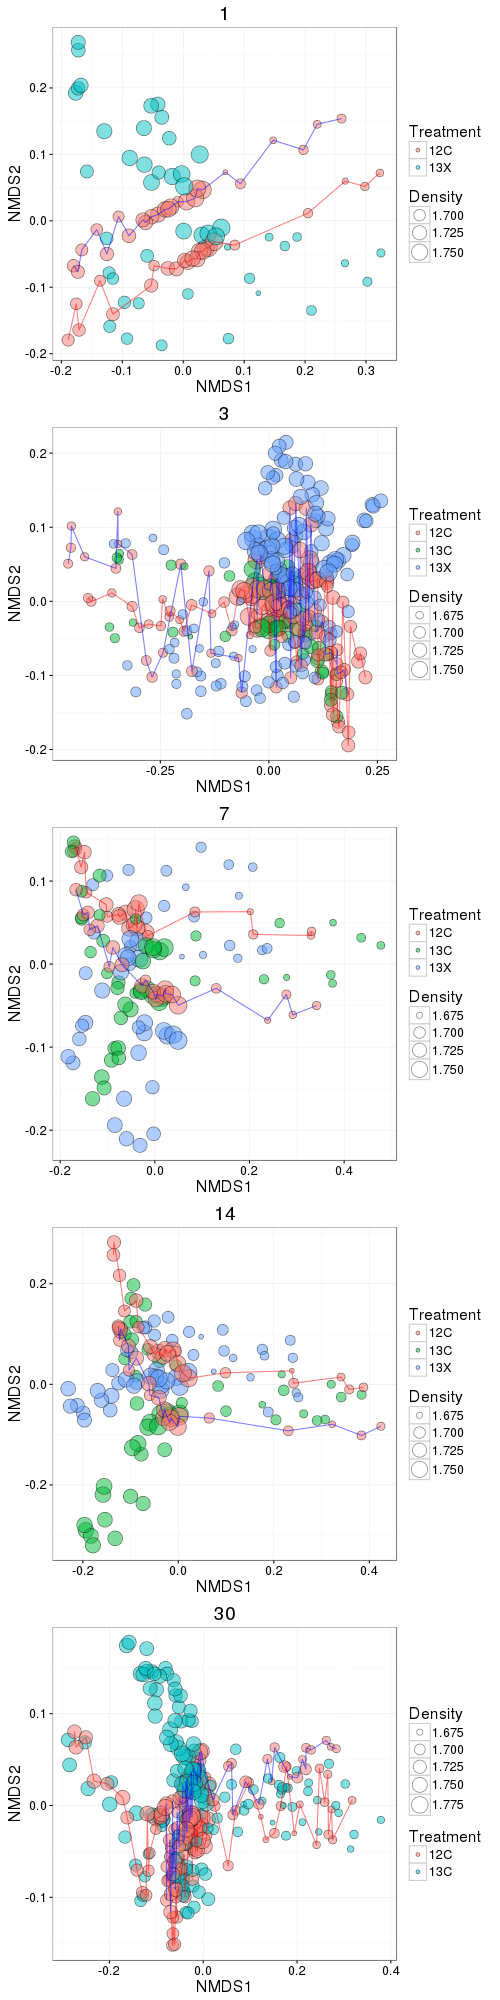

In [15]:
%%R -h 2000 -w 500

do.call("grid.arrange", c(plots.l, nrow=length(names(plots.l))))

In [16]:
%%R

make.plot.facet = function(tbl, title=''){
    p = ggplot(tbl, aes(x=NMDS1, y=NMDS2)) +
        geom_point(aes(fill = as.factor(Till), size = Density), pch=21, alpha=0.5) +
        scale_size(range=c(2,8)) +
        facet_grid(.~ Treatment) +
        labs(title=title) +
        theme_bw() +
        theme(
            text = element_text(size=16)
            )
    return(p)
    }

plots.l = list()
for (day in names(nmds.plot.l)){
    plots.l[[day]] = make.plot.facet(nmds.plot.l[[day]], title=day)
    }

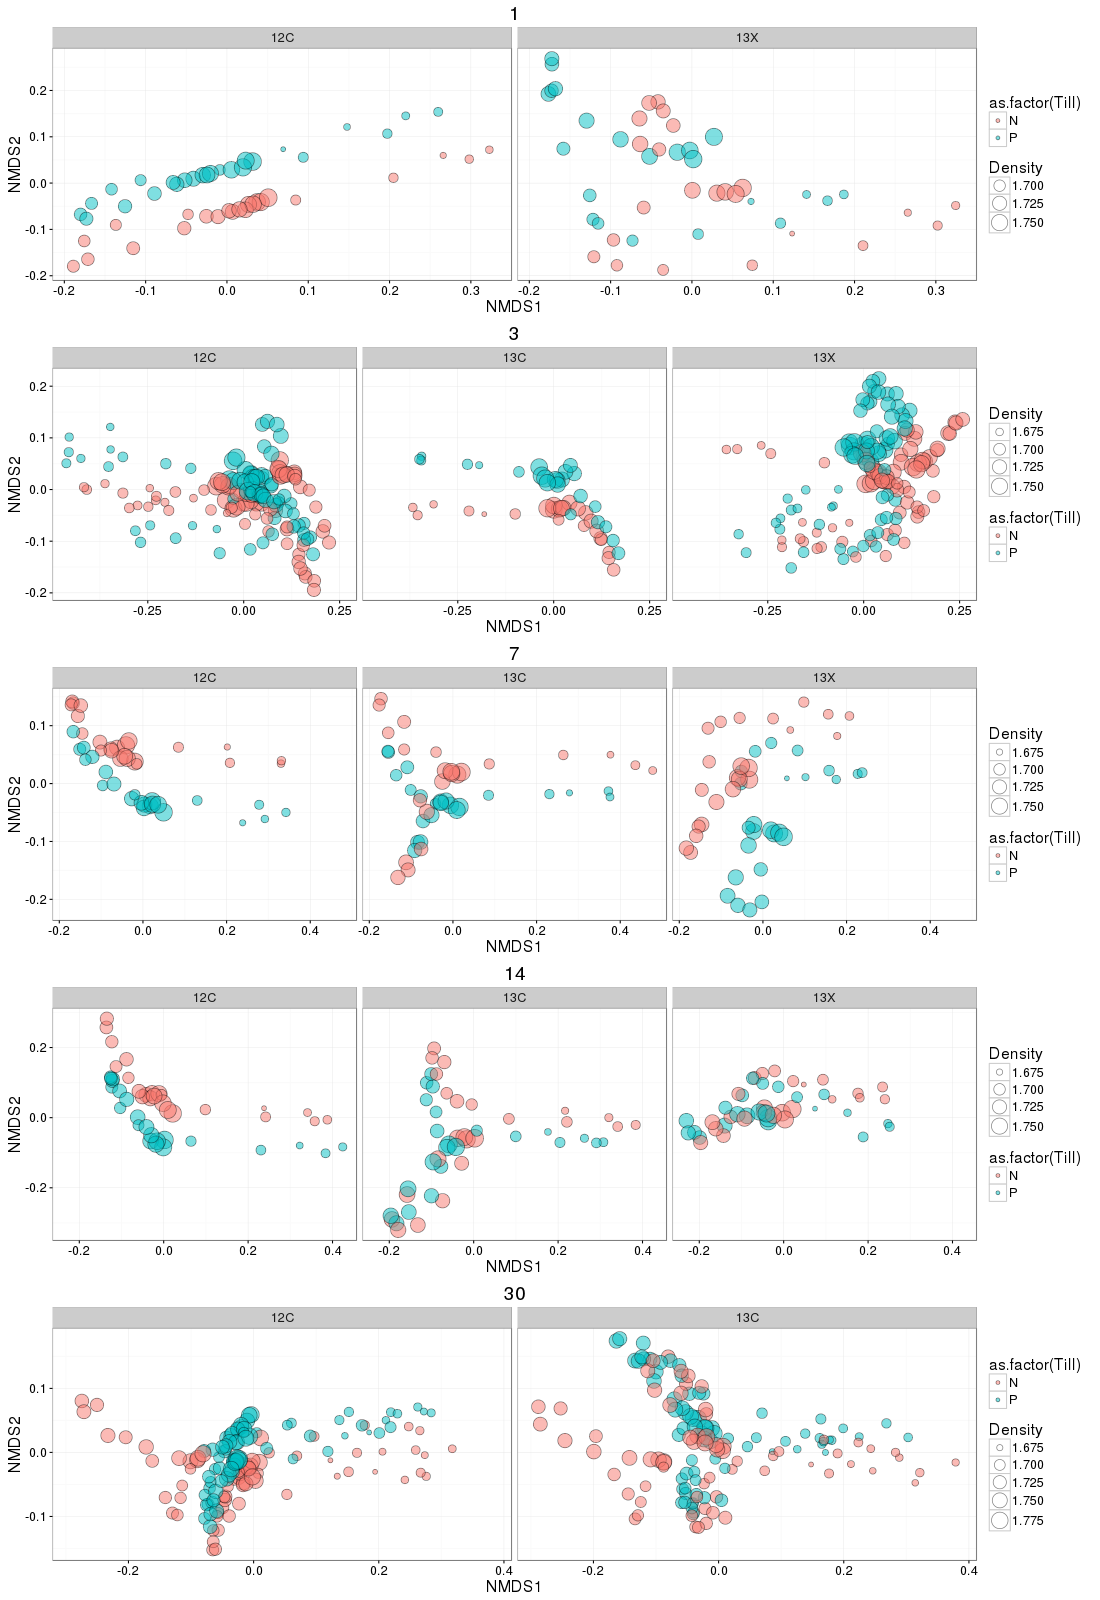

In [17]:
%%R -h 1600 -w 1100


do.call("grid.arrange", c(plots.l, nrow=length(names(plots.l))))

### Assessing microcosm replicates

In [18]:
%%R

tbl = do.call('rbind', nmds.plot.l)
tbl %>% head(n=3)

                              NMDS1       NMDS2          Full.sample Fraction
1.12C.PTH.D1.R4.Frac23 -0.008682757  0.02855367 12C.PTH.D1.R4.Frac23       23
1.12C.PTH.D1.R4.Frac20 -0.166520092 -0.04376957 12C.PTH.D1.R4.Frac20       20
1.12C.PTH.D1.R4.Frac21 -0.141905279 -0.01314305 12C.PTH.D1.R4.Frac21       21
                       PrimerF PrimerR Barcode Rev.index Fwd.index Treatment
1.12C.PTH.D1.R4.Frac23    515f    806r     144  ctgcgtag  gtcagata       12C
1.12C.PTH.D1.R4.Frac20    515f    806r     141  ctgcgtag  acgtctcg       12C
1.12C.PTH.D1.R4.Frac21    515f    806r     142  ctgcgtag  tcgacgag       12C
                       Day Replicate Pool Land_Management      Gradient
1.12C.PTH.D1.R4.Frac23   1         4    1             PTH 12C.PTH.D1.R4
1.12C.PTH.D1.R4.Frac20   1         4    1             PTH 12C.PTH.D1.R4
1.12C.PTH.D1.R4.Frac21   1         4    1             PTH 12C.PTH.D1.R4
                             Experiment Month Year Number Till OM Soil_Moisture
1.12C.PTH.D1

In [19]:
%%R -h 2000 -w 800

tbl.rep.s = tbl %>%
    select(Day, Treatment, Replicate) %>%
    distinct() %>%
    group_by(Day, Treatment) %>%
    summarize(n_rep = n()) %>%
    ungroup %>%
    filter(n_rep > 1)
tbl.rep.s %>% head(n=6)

Source: local data frame [4 x 3]

    Day Treatment n_rep
  (int)    (fctr) (int)
1     3       12C     3
2     3       13X     3
3    30       12C     3
4    30       13C     3


In [20]:
%%R
tbl.j = inner_join(tbl, tbl.rep.s, c('Day' = 'Day',
                                     'Treatment' = 'Treatment'))
tbl.j %>% head(n=3)

        NMDS1       NMDS2          Full.sample Fraction PrimerF PrimerR Barcode
1 -0.20536921 -0.02466345 12C.NTH.D3.R4.Frac28       28    515f    806r     174
2  0.06470130 -0.08103989 12C.NTH.D3.R4.Frac22       22    515f    806r     168
3 -0.08117329 -0.07403084 13X.NTH.D3.R4.Frac28       28    515f    806r      48
  Rev.index Fwd.index Treatment Day Replicate Pool Land_Management
1  gtctgcta  tcgacgag       12C   3         4    1             NTH
2  actacgac  gtcagata       12C   3         4    1             NTH
3  ctgcgtag  gacaccgt       13X   3         4    1             NTH
       Gradient       Experiment Month Year Number Till OM Soil_Moisture
1 12C.NTH.D3.R4 Chazy_SIP_515806  <NA>   NA     NA    N  H            NA
2 12C.NTH.D3.R4 Chazy_SIP_515806  <NA>   NA     NA    N  H            NA
3 13X.NTH.D3.R4 Chazy_SIP_515806  <NA>   NA     NA    N  H            NA
  Soil_Temp  Density Sample_Date  X X.1 n_rep
1        NA 1.677228             NA  NA     3
2        NA 1.697991        

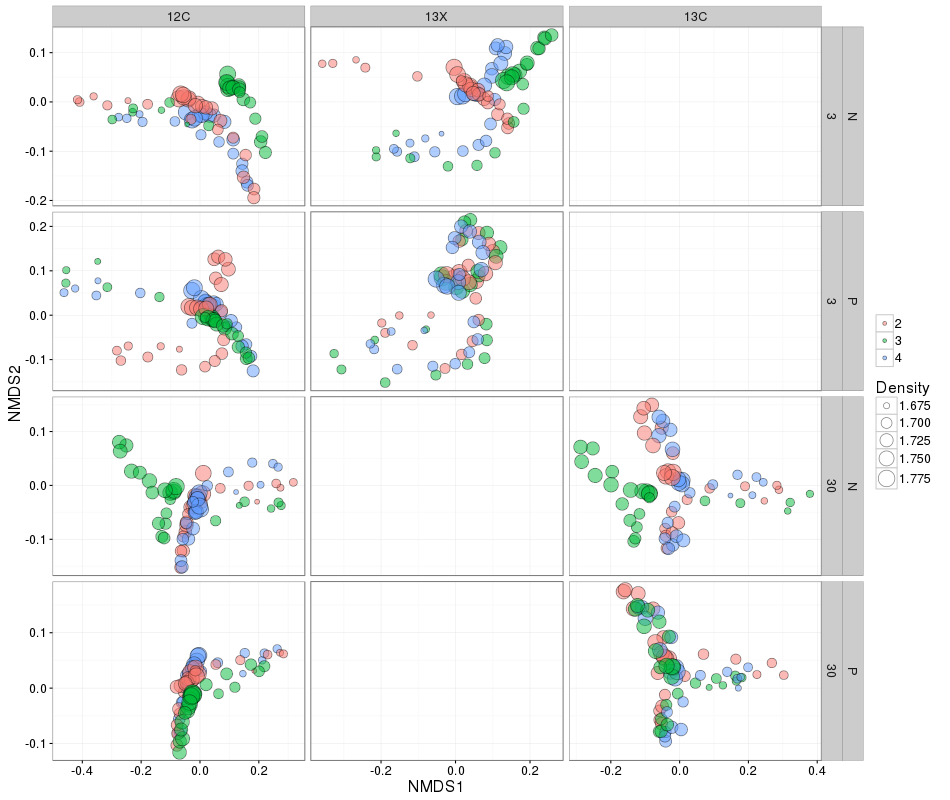

In [21]:
%%R -w 950 -h 800

ggplot(tbl.j, aes(x=NMDS1, y=NMDS2)) +
    geom_point(aes(fill = Replicate %>% as.character, 
                   size = Density), pch=21, alpha=0.5) +
    scale_size(range=c(2,8)) +
    scale_fill_discrete('') +
    facet_grid( Day ~ Till ~ Treatment , scale='free') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )


# Analyzing just 'core' dataset

In [22]:
%%R
tbl.meta = physeq.SIP.core %>% sample_data
u.day = tbl.meta$Day %>% unique

physeq.SIP.core.l = list()
for (d in as.character(u.day)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.SIP.core, Day == d)
    physeq.SIP.core.l[[d]] = subset_samples(tmp, ! is.na(Density))
    print(d)
    physeq.SIP.core.l[[d]] %>% print
    }

[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 142 samples ]
sample_data() Sample Data:       [ 142 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "7"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 140 samples ]
sample_data() Sample Data:       [ 140 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "14"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 139 samples ]
sample_data() Sample Data:       [ 139 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "1"
phyloseq-class experiment-le

In [23]:
%%R 

calc.wunif.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }

wunif.dist.l = lapply(physeq.SIP.core.l, calc.wunif.dist, cores=nprocs)

In [24]:
%%R
# nmds ordinations
nmds.l = list()
for (day in names(wunif.dist.l)){
    nmds.l[[day]] = ordinate(physeq.SIP.core.l[[day]],
                             method = "NMDS", 
                             distance = wunif.dist.l[[day]])
    }

Run 0 stress 0.09529462 
Run 1 stress 0.09529457 
... New best solution
... procrustes: rmse 4.678336e-05  max resid 0.0003478941 
*** Solution reached
Run 0 stress 0.09778911 
Run 1 stress 0.1220036 
Run 2 stress 0.1551215 
Run 3 stress 0.0977901 
... procrustes: rmse 0.0001629061  max resid 0.001450543 
*** Solution reached
Run 0 stress 0.1245344 
Run 1 stress 0.1313812 
Run 2 stress 0.1730431 
Run 3 stress 0.1445641 
Run 4 stress 0.1269723 
Run 5 stress 0.1357365 
Run 6 stress 0.1388567 
Run 7 stress 0.143326 
Run 8 stress 0.1451989 
Run 9 stress 0.1566999 
Run 10 stress 0.1395959 
Run 11 stress 0.1440892 
Run 12 stress 0.1517066 
Run 13 stress 0.1359968 
Run 14 stress 0.1238255 
... New best solution
... procrustes: rmse 0.009242529  max resid 0.1037967 
Run 15 stress 0.1515663 
Run 16 stress 0.126045 
Run 17 stress 0.168713 
Run 18 stress 0.1344022 
Run 19 stress 0.1362239 
Run 20 stress 0.128429 
Run 0 stress 0.1407638 
Run 1 stress 0.1614518 
Run 2 stress 0.1407639 
... procrust

In [25]:
%%R

names.ord = nmds.l %>% names %>% as.numeric %>% sort %>% as.character

# nmds ordination plots
nmds.plot.l = list()
for (day in names.ord){
    nmds.plot.l[[day]] = plot_ordination(physeq.SIP.core.l[[day]], 
                                         nmds.l[[day]], 
                                         justDF = TRUE)
    }

In [26]:
%%R

make.plot = function(tbl, title=''){
    
    #tbl.cell = filter(tbl, Treatment != '13X', Day != 1)
    tbl.f = filter(tbl, Treatment == '12C', Till == "N")
    tbl.p = filter(tbl, Treatment == "12C", Till == "P")
    
    p = ggplot(tbl, aes(x=NMDS1, y=NMDS2)) +
        geom_point(aes(color = Treatment, 
                       size = Density, shape = Till), 
                    alpha=0.5) +
        scale_size(range=c(2,8)) +
        labs(title=title) +
        theme_bw() +
        theme(
            text = element_text(size=16)
            )
    if(nrow(tbl.f) > 0){
        p = p + geom_line(data=tbl.f, alpha=0.5, color='red')
        }
    
    
    if(nrow(tbl.p) > 0){
        p = p + geom_line(data=tbl.p, alpha=0.5, color='blue')
        }
    
    return(p)
    }
    

      

# run
plots.l = list()
for (day in names(nmds.plot.l)){
    plots.l[[day]] = make.plot(nmds.plot.l[[day]], title=day)
    }

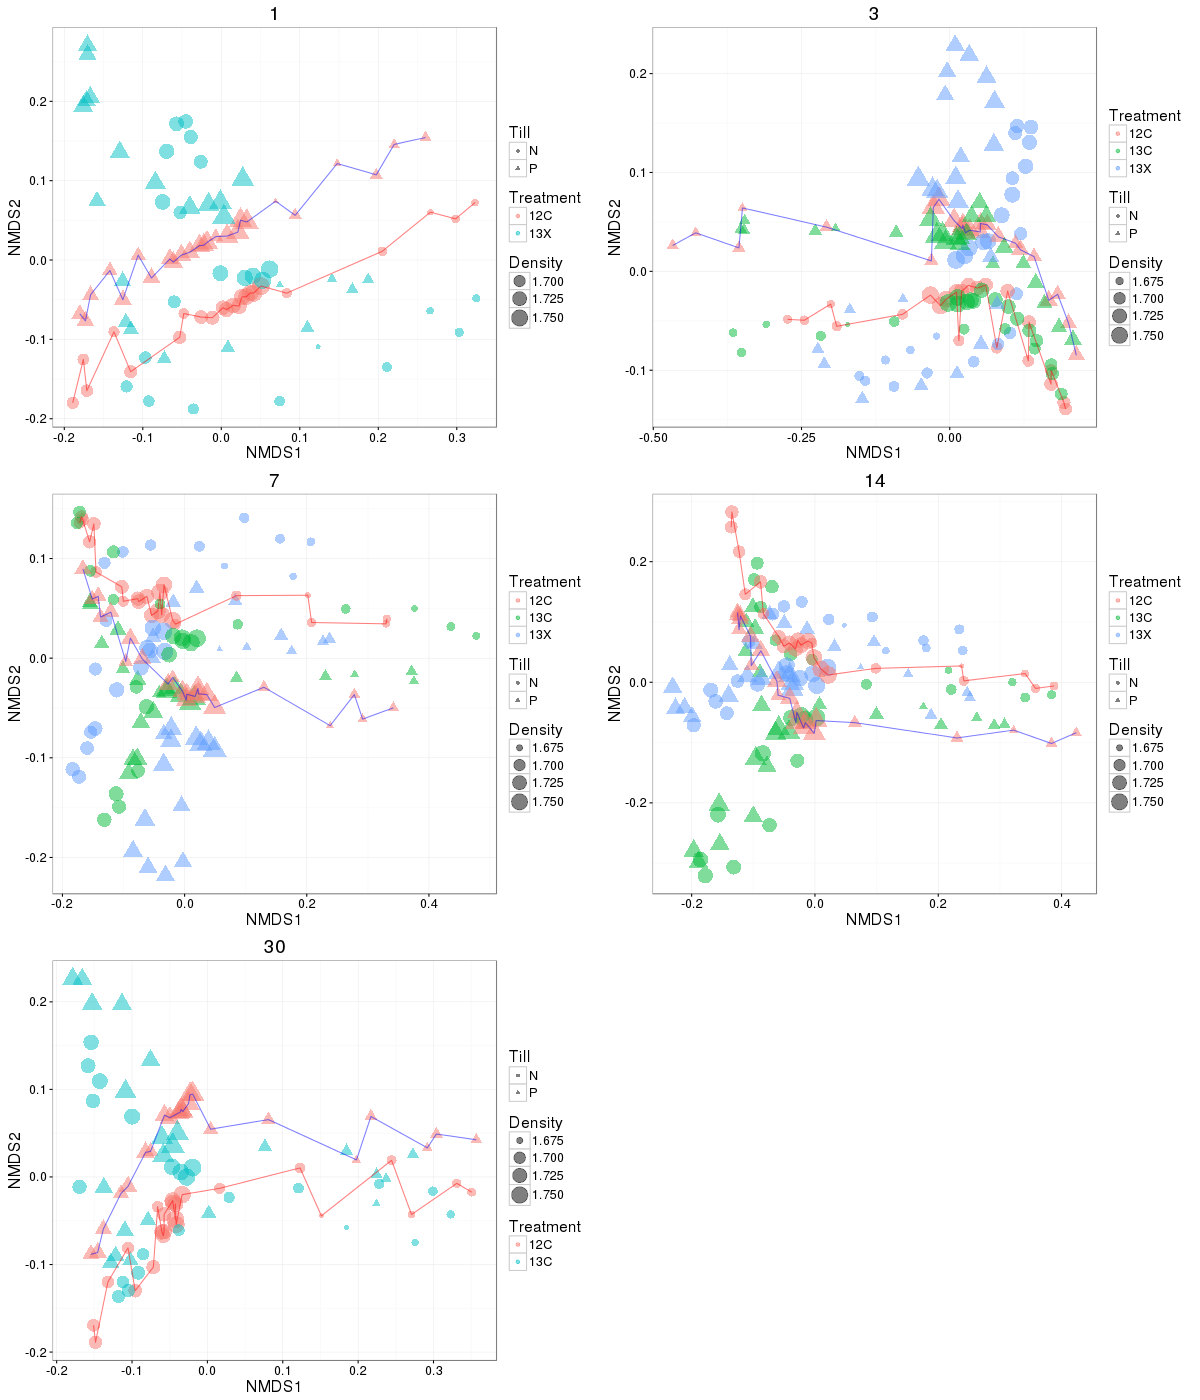

In [27]:
%%R -h 1400 -w 1200

do.call("grid.arrange", c(plots.l, nrow=3))

In [28]:
%%R

make.plot.facet = function(tbl, title=''){
    p = ggplot(tbl, aes(x=NMDS1, y=NMDS2)) +
        geom_point(aes(fill = Treatment, size = Density), pch=21, alpha=0.5) +
        scale_size(range=c(2,8)) +
        facet_grid(. ~ Till) +
        labs(title=title) +
        theme_bw() +
        theme(
            text = element_text(size=16)
            )
    return(p)
    }

plots.l = list()
for (day in names(nmds.plot.l)){
    plots.l[[day]] = make.plot.facet(nmds.plot.l[[day]], title=day)
    }

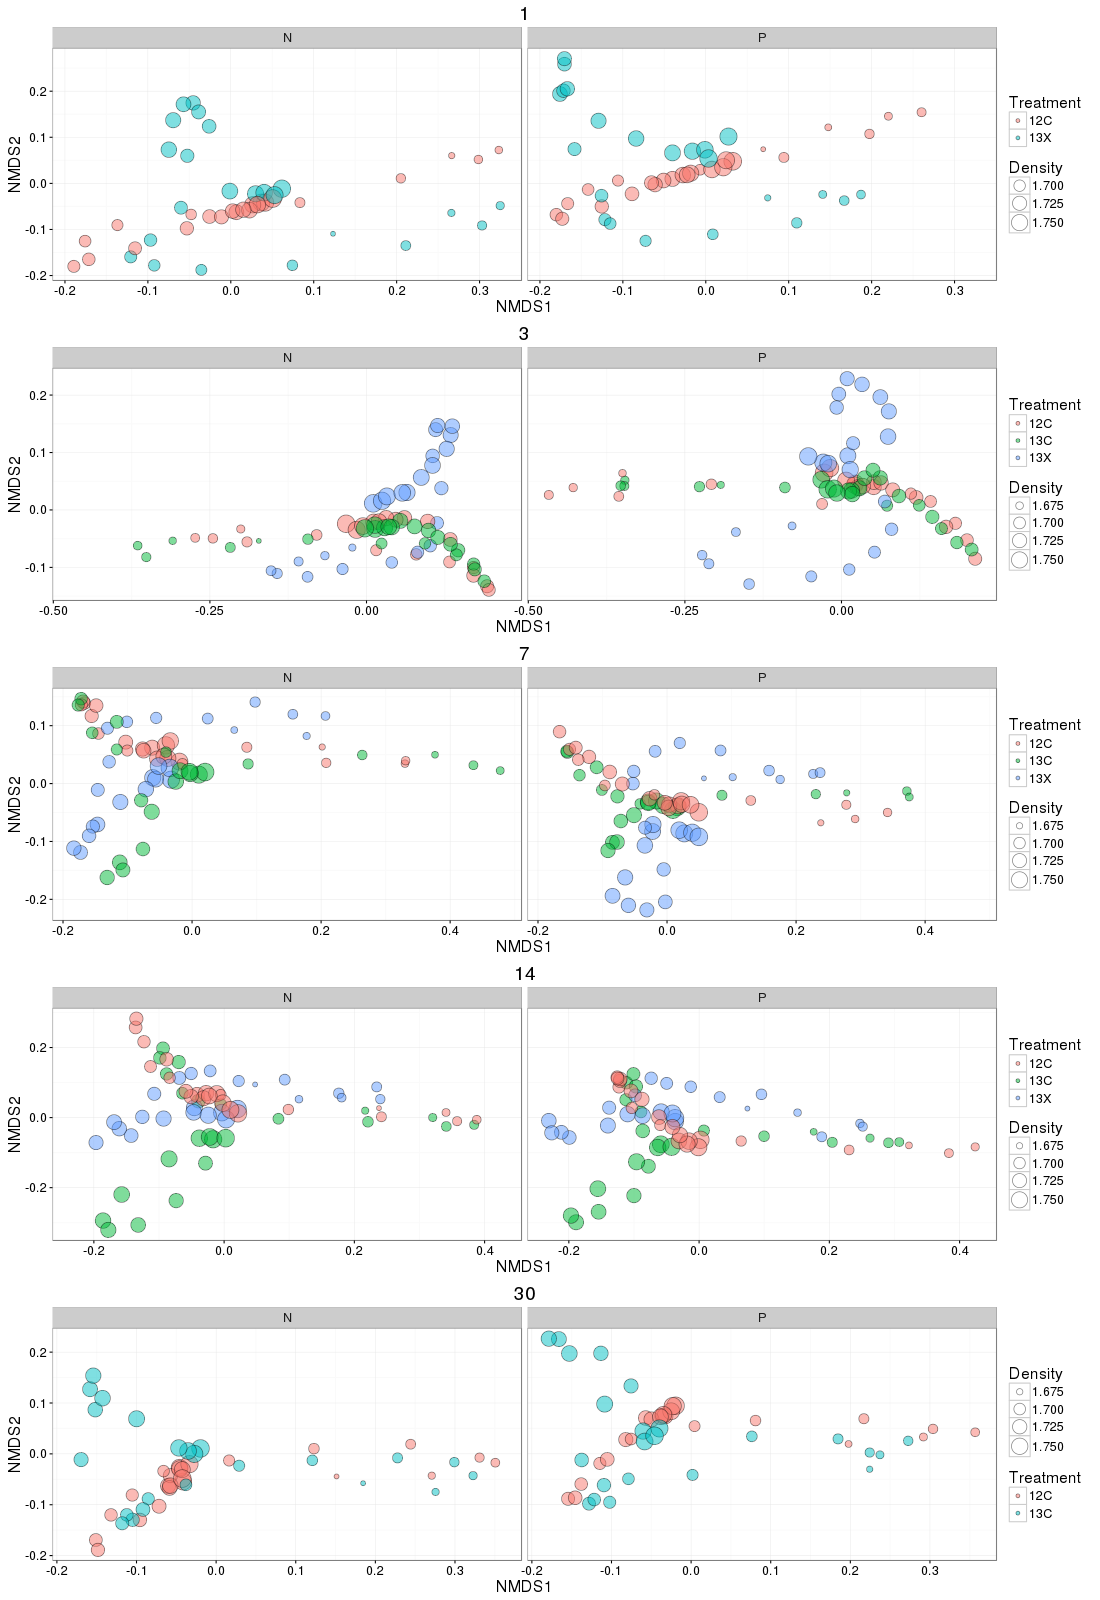

In [29]:
%%R -h 1600 -w 1100

do.call("grid.arrange", c(plots.l, nrow=length(names(plots.l))))

## Adonis test

### Creating treatment/land management combined column


In [30]:
%%R
physeq.SIP.core.m$comTreat = paste(physeq.SIP.core.m$Treatment, physeq.SIP.core.m$Land_Management, sep = ".")

In [31]:
%%R

adonis.SIP = function(d, physeq.meta, comTreat, day, permutations = 999, BD_min=0, BD_max=2){
    # adonis on SIP data
    stopifnot(comTreat %>% length == 1)
   
    
    control = function(comTreat){
    # if BD_range is negative, use BD_to_set value to set new BD_max
    if (comTreat %in% c("13C.NTH", "13X.NTH")){
        return("12C.NTH")
    } else {
        return("12C.PTH")
    }
}
    
    
    comTreat = c(comTreat, control(comTreat))
    print(comTreat)
       
    # distance metadata
    ## check whether treatment in metadata
    if(!any(physeq.meta$Day == day &
           physeq.meta$comTreat == comTreat[1] &
           physeq.meta$Density >= BD_min & 
           physeq.meta$Density <= BD_max)){    
        return(NA)
        }
   

    ## selecting metadata
    physeq.d1.m = prune_samples(physeq.meta$Day == day &
                                physeq.meta$comTreat %in% comTreat &
                                physeq.meta$Density >= BD_min & 
                                physeq.meta$Density <= BD_max, physeq.meta) %>% 
        sample_data %>% as.matrix %>% as.data.frame    

    
    # parse distance for just 1 treatment
    samp.to.keep = physeq.d1.m$Full.sample %>% as.vector
    dist1 = d %>% as.matrix %>% as.data.frame 
    dist1 = dist1[samp.to.keep, samp.to.keep]

    
    # stats
    cat('Treatment: ', comTreat, '\n')
    cat('Day: ', day, '\n')
    cat('Number of samples: ', dist1 %>% ncol, '\n')    
    
    # covert to distance matrix
    dist1 = dist1 %>% as.dist
    dist1.labels = attributes(dist1)[['Labels']]
    
    ## ordering metadata by distance matrix
    physeq.d1.m = physeq.d1.m[dist1.labels,]

    # check that labels are in order
    stopifnot(all(dist1.labels == physeq.d1.m$Full.sample))
    
    # adonis
    adonis(dist1 ~ Treatment, data=physeq.d1.m, permutations=permutations)  
}
    
#-- test --#
day = '30'
res = adonis.SIP(wunif.dist.l[[day]], physeq.SIP.core.m, comTreat='13C.NTH', day=day)
res

[1] "13C.NTH" "12C.NTH"
Treatment:  13C.NTH 12C.NTH 
Day:  30 
Number of samples:  47 

Call:
adonis(formula = dist1 ~ Treatment, data = physeq.d1.m, permutations = permutations) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)
Treatment  1   0.09059 0.090585  2.2011 0.04663    0.1
Residuals 45   1.85194 0.041154         0.95337       
Total     46   1.94252                  1.00000       


In [32]:
%%R

#physeq.SIP.core.m.N = filter(physeq.SIP.core.m), Till == "N")
# calling adonis for each 12C-con vs 13C-treatment-Day combination

# all substrates

substrates = lapply(wunif.dist.l, get.substrates) %>% unlist %>% unique
substrates = substrates[!(substrates %in% c('12C.NTH', '12C.PTH'))]
substrates = append(substrates, 'blank')


# adonis on each day-substrate
adonis.SIP.w = function(d, substrates, ...){
    days = d %>% as.matrix %>% colnames
    days = gsub('.+D([0-9]+)\\..+', '\\1', days) %>% unique %>% as.vector
    #days = c('3','7','14','30')
    day = days[1]
    print(days)
    print(substrates)
    sapply(substrates, function(x) adonis.SIP(comTreat=x, d=d, day=day, ...))
}

    
adonis.res = lapply(wunif.dist.l, adonis.SIP.w, 
       substrates=substrates,
       physeq.meta=physeq.SIP.core.m, 
       permutations = 999)

adonis.res[[1]][[1]]


Error in match.fun(FUN) : object 'get.substrates' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in match.fun(FUN) : object 'get.substrates' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rp

In [33]:
%%R
# pulling out p-values
get.pval = function(x){
    ret = lapply(x, function(y) ifelse(is.na(y), NA, y[['aov.tab']][['Pr(>F)']]))
    ret = do.call(rbind, ret)
    ret[,1]
    }
## extract p-values
adonis.pval = lapply(adonis.res, get.pval)
## format results
adonis.pval = do.call(rbind, adonis.pval) %>%
    as.data.frame %>%
    mutate(Day = rownames(.)) %>%
    gather(Substrate, p_value, -Day)
## multiple hypothesis correction
adonis.pval = adonis.pval %>%
    mutate(q_value = p.adjust(p_value, method='BH'))
adonis.pval %>% head(n=10)


Error in lapply(adonis.res, get.pval) : object 'adonis.res' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in lapply(adonis.res, get.pval) : object 'adonis.res' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [34]:
%%R -h 350 -w 450
# plotting
q_value_cutoff = 0.05
adonis.pval = adonis.pval %>%
    mutate(significant = q_value < q_value_cutoff) %>%
    filter(Substrate != 'blank')

adonis.pval$Day = reorder(adonis.pval$Day, adonis.pval$Day %>% as.numeric)
u.sub = adonis.pval$Substrate %>% as.character %>% unique %>% sort(decreasing=T)
adonis.pval$Substrate = factor(adonis.pval$Substrate, levels=u.sub)

ggplot(adonis.pval, aes(Day, Substrate, fill=q_value)) +
    geom_tile() +
    geom_point(aes(color=significant, alpha=significant), size=9, shape='*') +
    scale_fill_gradient(high="#132B43", low="#56B1F7") +
    scale_color_manual(values=c('white', 'red')) +
    scale_alpha_manual(values=c(0,1)) +
    theme_bw() +
    theme(
        text=element_text(size=18)
    )


Error in eval(expr, envir, enclos) : object 'adonis.pval' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'adonis.pval' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [35]:
%%R
# pulling out R^2
get.R2 = function(x){
    ret = lapply(x, function(y) ifelse(is.na(y), NA, y[['aov.tab']][['R2']]))
    ret = do.call(rbind, ret)
    ret[,1]
    }
## extract p-values
adonis.R2 = lapply(adonis.res, get.R2)
## format results
adonis.R2 = do.call(rbind, adonis.R2) %>%
    as.data.frame %>%
    mutate(Day = rownames(.)) %>%
    gather(Substrate, R2, -Day)
adonis.R2 %>% head(n=5)


Error in lapply(adonis.res, get.R2) : object 'adonis.res' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in lapply(adonis.res, get.R2) : object 'adonis.res' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [36]:
%%R -h 350 -w 450
# plotting
adonis.R2 = adonis.R2 %>%
    filter(Substrate != 'blank')

adonis.R2$Day = reorder(adonis.R2$Day, adonis.R2$Day %>% as.numeric)
u.sub = adonis.R2$Substrate %>% as.character %>% unique %>% sort(decreasing=T)
adonis.R2$Substrate = factor(adonis.R2$Substrate, levels=u.sub)

ggplot(adonis.R2, aes(Day, Substrate, fill=R2)) +
    geom_tile() +
    #scale_fill_gradient(high="#132B43", low="#56B1F7") +
    theme_bw() +
    theme(
        text=element_text(size=18)
    )


Error in eval(expr, envir, enclos) : object 'adonis.R2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'adonis.R2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## Adonis on just heavy fractions (still core dataset)

In [37]:
%%R
BD_min = 1.7125

In [38]:
%%R
# calling adonis for each 12C-con vs 13C-treatment-Day combination

# all substrates
get.substrates = function(d){
    x = d %>% as.matrix %>% colnames 
    x = gsub('\\.D[1-9]+.+', '', x)
    return(x)
}
substrates = lapply(wunif.dist.l, get.substrates) %>% unlist %>% unique
substrates = substrates[!(substrates %in% c("12C.NTH", "12C.PTH")) ]

substrates = append(substrates, 'blank')

# adonis on each day-substrate
adonis.SIP.w = function(d, substrates, ...){
    days = d %>% as.matrix %>% colnames
    days = gsub('.+D([0-9]+)\\..+', '\\1', days) %>% unique %>% as.vector
    day = days[1]
    sapply(substrates, function(x) adonis.SIP(comTreat=x, d=d, day=day, ...))
}

adonis.res = lapply(wunif.dist.l, adonis.SIP.w, 
       substrates=substrates,
       physeq.meta=physeq.SIP.core.m, 
       permutations=999,
       BD_min=BD_min,
       BD_max=2)

adonis.res[[1]][[1]]

[1] "13X.NTH" "12C.NTH"
Treatment:  13X.NTH 12C.NTH 
Day:  3 
Number of samples:  26 
[1] "13C.NTH" "12C.NTH"
Treatment:  13C.NTH 12C.NTH 
Day:  3 
Number of samples:  25 
[1] "13C.PTH" "12C.PTH"
Treatment:  13C.PTH 12C.PTH 
Day:  3 
Number of samples:  27 
[1] "13X.PTH" "12C.PTH"
Treatment:  13X.PTH 12C.PTH 
Day:  3 
Number of samples:  27 
[1] "blank"   "12C.PTH"
[1] "13X.NTH" "12C.NTH"
Treatment:  13X.NTH 12C.NTH 
Day:  7 
Number of samples:  26 
[1] "13C.NTH" "12C.NTH"
Treatment:  13C.NTH 12C.NTH 
Day:  7 
Number of samples:  26 
[1] "13C.PTH" "12C.PTH"
Treatment:  13C.PTH 12C.PTH 
Day:  7 
Number of samples:  26 
[1] "13X.PTH" "12C.PTH"
Treatment:  13X.PTH 12C.PTH 
Day:  7 
Number of samples:  27 
[1] "blank"   "12C.PTH"
[1] "13X.NTH" "12C.NTH"
Treatment:  13X.NTH 12C.NTH 
Day:  14 
Number of samples:  26 
[1] "13C.NTH" "12C.NTH"
Treatment:  13C.NTH 12C.NTH 
Day:  14 
Number of samples:  26 
[1] "13C.PTH" "12C.PTH"
Treatment:  13C.PTH 12C.PTH 
Day:  14 
Number of samples:  25 
[1]

In [39]:
%%R
## extract p-values
adonis.pval = lapply(adonis.res, get.pval)
## format results
adonis.pval = do.call(rbind, adonis.pval) %>%
    as.data.frame %>%
    mutate(Day = rownames(.)) %>%
    gather(Substrate, p_value, -Day)
## multiple hypothesis correction
adonis.pval = adonis.pval %>%
    mutate(q_value = p.adjust(p_value, method='BH'))
adonis.pval 

   Day Substrate p_value     q_value
1    3   13X.NTH   0.001 0.001230769
2    7   13X.NTH   0.001 0.001230769
3   14   13X.NTH   0.001 0.001230769
4    1   13X.NTH   0.001 0.001230769
5   30   13X.NTH      NA          NA
6    3   13C.NTH   0.397 0.397000000
7    7   13C.NTH   0.001 0.001230769
8   14   13C.NTH   0.001 0.001230769
9    1   13C.NTH      NA          NA
10  30   13C.NTH   0.001 0.001230769
11   3   13C.PTH   0.010 0.010666667
12   7   13C.PTH   0.003 0.003428571
13  14   13C.PTH   0.001 0.001230769
14   1   13C.PTH      NA          NA
15  30   13C.PTH   0.001 0.001230769
16   3   13X.PTH   0.001 0.001230769
17   7   13X.PTH   0.001 0.001230769
18  14   13X.PTH   0.001 0.001230769
19   1   13X.PTH   0.001 0.001230769
20  30   13X.PTH      NA          NA
21   3     blank      NA          NA
22   7     blank      NA          NA
23  14     blank      NA          NA
24   1     blank      NA          NA
25  30     blank      NA          NA


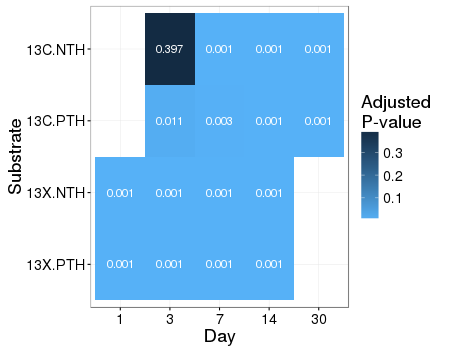

In [40]:
%%R -h 350 -w 450
# plotting
q_value_cutoff = 0.02
adonis.pval = adonis.pval %>%
    mutate(significant = q_value < q_value_cutoff) %>%
    filter(Substrate != 'blank')

adonis.pval$Day = reorder(adonis.pval$Day, adonis.pval$Day %>% as.numeric)
u.sub = adonis.pval$Substrate %>% as.character %>% unique %>% sort(decreasing=T)
adonis.pval$Substrate = factor(adonis.pval$Substrate, levels=u.sub)
adonis.pval2 = filter(adonis.pval, !(is.na(significant)))


p.adonis = ggplot(adonis.pval2, aes(Day, Substrate, fill=q_value)) +
    geom_tile() +
    #geom_point(aes(color=significant), size=9, shape='*') +
    scale_fill_gradient('Adjusted\nP-value', high="#132B43", low="#56B1F7") +
   # scale_color_manual(values=c('red', 'white')) +
    scale_alpha_manual(values=c(0,1)) +
    theme_bw() +
    theme(
        text=element_text(size=18)
    ) + geom_text(aes(label = round(q_value, digits =3)), color = 'white')
p.adonis

In [41]:
%%R 

outFile = 'adonis_heavyFrac.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.adonis, height=6, width=6.5)

In [42]:
%%R
# pulling out R^2
## extract p-values
adonis.R2 = lapply(adonis.res, get.R2)
## format results
adonis.R2 = do.call(rbind, adonis.R2) %>%
    as.data.frame %>%
    mutate(Day = rownames(.)) %>%
    gather(Substrate, R2, -Day)
adonis.R2 %>% arrange(Substrate, as.numeric(Day))#%>% head(n=5)

   Day Substrate         R2
1    1   13C.NTH         NA
2    3   13C.NTH 0.03353385
3    7   13C.NTH 0.27920225
4   14   13C.NTH 0.29745735
5   30   13C.NTH 0.28172726
6    1   13C.PTH         NA
7    3   13C.PTH 0.15419609
8    7   13C.PTH 0.20503163
9   14   13C.PTH 0.25928473
10  30   13C.PTH 0.31983280
11   1   13X.NTH 0.40230122
12   3   13X.NTH 0.34920371
13   7   13X.NTH 0.40893125
14  14   13X.NTH 0.27157668
15  30   13X.NTH         NA
16   1   13X.PTH 0.39637040
17   3   13X.PTH 0.33092898
18   7   13X.PTH 0.29956187
19  14   13X.PTH 0.30463327
20  30   13X.PTH         NA
21   1     blank         NA
22   3     blank         NA
23   7     blank         NA
24  14     blank         NA
25  30     blank         NA


In [43]:
%%R
adonis.R2 %>% group_by(Substrate) %>% na.omit %>% summarise(mean = mean(R2), sd = sd(R2))

Source: local data frame [4 x 3]

  Substrate      mean         sd
      (chr)     (dbl)      (dbl)
1   13C.NTH 0.2229802 0.12655552
2   13C.PTH 0.2345863 0.07121105
3   13X.NTH 0.3580032 0.06351628
4   13X.PTH 0.3328736 0.04450772


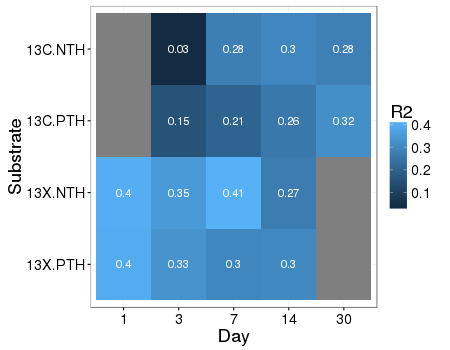

In [44]:
%%R -h 350 -w 450
# plotting
adonis.R2 = adonis.R2 %>%
    filter(Substrate != 'blank')

adonis.R2$Day = reorder(adonis.R2$Day, adonis.R2$Day %>% as.numeric)
u.sub = adonis.R2$Substrate %>% as.character %>% unique %>% sort(decreasing=T)
adonis.R2$Substrate = factor(adonis.R2$Substrate, levels=u.sub)

ggplot(adonis.R2, aes(Day, Substrate, fill=R2)) +
    geom_tile() +
    geom_text(aes(label = round(R2, digits = 2)), color = 'white') +
    theme_bw() +
    theme(
        text=element_text(size=18)
    ) 

In [45]:
%%R
total = left_join(adonis.pval2, adonis.R2)
total %>% as.data.frame

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("Day", "Substrate")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


   Day Substrate p_value     q_value significant         R2
1    3   13X.NTH   0.001 0.001230769        TRUE 0.34920371
2    7   13X.NTH   0.001 0.001230769        TRUE 0.40893125
3   14   13X.NTH   0.001 0.001230769        TRUE 0.27157668
4    1   13X.NTH   0.001 0.001230769        TRUE 0.40230122
5    3   13C.NTH   0.397 0.397000000       FALSE 0.03353385
6    7   13C.NTH   0.001 0.001230769        TRUE 0.27920225
7   14   13C.NTH   0.001 0.001230769        TRUE 0.29745735
8   30   13C.NTH   0.001 0.001230769        TRUE 0.28172726
9    3   13C.PTH   0.010 0.010666667        TRUE 0.15419609
10   7   13C.PTH   0.003 0.003428571        TRUE 0.20503163
11  14   13C.PTH   0.001 0.001230769        TRUE 0.25928473
12  30   13C.PTH   0.001 0.001230769        TRUE 0.31983280
13   3   13X.PTH   0.001 0.001230769        TRUE 0.33092898
14   7   13X.PTH   0.001 0.001230769        TRUE 0.29956187
15  14   13X.PTH   0.001 0.001230769        TRUE 0.30463327
16   1   13X.PTH   0.001 0.001230769    

In [46]:
%%R
library(htmlTable)
test = htmlTable(as.matrix(total))


In [47]:
%%R
print(test)

In [48]:
%%R
total$sig[total$p_value <= 0.001] = "***"
total$sig[total$p_value <= 0.01 & total$p_value > 0.001] = "**"
total$sig[total$p_value <= 0.05 & total$p_value > 0.01] = "*"
total$sig[total$p_value > 0.05] = " "

In [49]:
%%R
(total)

   Day Substrate p_value     q_value significant         R2 sig
1    3   13X.NTH   0.001 0.001230769        TRUE 0.34920371 ***
2    7   13X.NTH   0.001 0.001230769        TRUE 0.40893125 ***
3   14   13X.NTH   0.001 0.001230769        TRUE 0.27157668 ***
4    1   13X.NTH   0.001 0.001230769        TRUE 0.40230122 ***
5    3   13C.NTH   0.397 0.397000000       FALSE 0.03353385    
6    7   13C.NTH   0.001 0.001230769        TRUE 0.27920225 ***
7   14   13C.NTH   0.001 0.001230769        TRUE 0.29745735 ***
8   30   13C.NTH   0.001 0.001230769        TRUE 0.28172726 ***
9    3   13C.PTH   0.010 0.010666667        TRUE 0.15419609  **
10   7   13C.PTH   0.003 0.003428571        TRUE 0.20503163  **
11  14   13C.PTH   0.001 0.001230769        TRUE 0.25928473 ***
12  30   13C.PTH   0.001 0.001230769        TRUE 0.31983280 ***
13   3   13X.PTH   0.001 0.001230769        TRUE 0.33092898 ***
14   7   13X.PTH   0.001 0.001230769        TRUE 0.29956187 ***
15  14   13X.PTH   0.001 0.001230769    

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


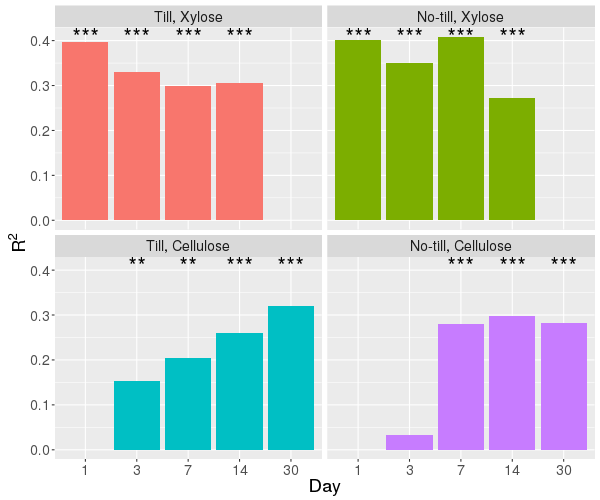

In [84]:
%%R -w 600 -h 500


names = c('13X.PTH' = "Till, Xylose",
          '13C.PTH' = "Till, Cellulose",
          '13X.NTH' = "No-till, Xylose",
          '13C.NTH' = "No-till, Cellulose"
                    )

p = ggplot(total, aes(x = Day, y = R2)) + geom_bar(stat = 'identity', position = 'dodge', aes(fill = Substrate)) + 
    facet_wrap(~Substrate, labeller = as_labeller(names))


p = p + geom_text(data = total, aes(label = sig), size = 8, y = 0.41)

p = p + theme(text = element_text(size = 18)) + ylab(expression('R'^ 2)) + guides(fill = FALSE)
p

In [86]:
%%R
ggsave('data/figs/12v13_Adonis.jpg', p, height=7, width=8)

## Playing with comparing heavy fractions across NT and PT

In [51]:
%%R

adonis.SIP = function(d, physeq.meta, comTreat, day, permutations = 999, BD_min=0, BD_max=2){
    # adonis on SIP data
    stopifnot(comTreat %>% length == 1)
   
    
    control = function(comTreat){
    # if BD_range is negative, use BD_to_set value to set new BD_max
    if (comTreat == "13C.NTH"){
        return("13C.PTH")
    }
        if (comTreat == "13X.NTH"){
        return("13X.PTH")
    }  
        if (comTreat %in% c("13C.PTH")){
        return("13C.NTH")
    } 
        if (comTreat %in% c("13X.PTH")){
        return("13X.NTH")
    } 
        if (comTreat %in% c("12C.NTH")){
        return("12C.PTH")
    } else {
        return("12C.NTH")
    }
}
    
    
    comTreat = c(comTreat, control(comTreat))
       
    # distance metadata
    ## check whether treatment in metadata
    if(!any(physeq.meta$Day == day &
           physeq.meta$comTreat == comTreat[1] &
           physeq.meta$Density >= BD_min & 
           physeq.meta$Density <= BD_max)){    
        return(NA)
        }
   
print(comTreat)
    ## selecting metadata
    physeq.d1.m = prune_samples(physeq.meta$Day == day &
                                physeq.meta$comTreat %in% comTreat &
                                physeq.meta$Density >= BD_min & 
                                physeq.meta$Density <= BD_max, physeq.meta) %>% 
        sample_data %>% as.matrix %>% as.data.frame    
    # parse distance for just 1 treatment
    samp.to.keep = physeq.d1.m$Full.sample %>% as.vector
    dist1 = d %>% as.matrix %>% as.data.frame 
    dist1 = dist1[samp.to.keep, samp.to.keep]

    # stats
    cat('Treatment: ', comTreat, '\n')
    cat('Day: ', day, '\n')
    cat('Number of samples: ', dist1 %>% ncol, '\n')    
    
    # covert to distance matrix
    dist1 = dist1 %>% as.dist
    dist1.labels = attributes(dist1)[['Labels']]
    
    ## ordering metadata by distance matrix
    physeq.d1.m = physeq.d1.m[dist1.labels,]

    # check that labels are in order
    stopifnot(all(dist1.labels == physeq.d1.m$Full.sample))
    
    # adonis
    adonis(dist1 ~ Till, data=physeq.d1.m, permutations=permutations)  
}
    
#-- test --#
day = '30'
res = adonis.SIP(wunif.dist.l[[day]], physeq.SIP.core.m, comTreat='13C.NTH', day=day)
res

[1] "13C.NTH" "13C.PTH"
Treatment:  13C.NTH 13C.PTH 
Day:  30 
Number of samples:  46 

Call:
adonis(formula = dist1 ~ Till, data = physeq.d1.m, permutations = permutations) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Till       1    0.1455 0.145499  3.1438 0.06668  0.029 *
Residuals 44    2.0364 0.046282         0.93332         
Total     45    2.1819                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [52]:
%%R
# calling adonis for each 12C-con vs 13C-treatment-Day combination

# all substrates
get.substrates = function(d){
    x = d %>% as.matrix %>% colnames 
    x = gsub('\\.D[1-9]+.+', '', x)
    return(x)
}
substrates = lapply(wunif.dist.l, get.substrates) %>% unlist %>% unique
substrates = substrates[!(substrates %in% c("12C.NTH", "12C.PTH")) ]

substrates = append(substrates, 'blank')

# adonis on each day-substrate
adonis.SIP.w = function(d, substrates, ...){
    days = d %>% as.matrix %>% colnames
    days = gsub('.+D([0-9]+)\\..+', '\\1', days) %>% unique %>% as.vector
    day = days[1]
    sapply(substrates, function(x) adonis.SIP(comTreat=x, d=d, day=day, ...))
}

adonis.res = lapply(wunif.dist.l, adonis.SIP.w, 
       substrates=substrates,
       physeq.meta=physeq.SIP.core.m, 
       permutations=5000,
       BD_min=BD_min,
       BD_max=2)

adonis.res[[1]][[1]]

[1] "13X.NTH" "13X.PTH"
Treatment:  13X.NTH 13X.PTH 
Day:  3 
Number of samples:  27 
[1] "13C.NTH" "13C.PTH"
Treatment:  13C.NTH 13C.PTH 
Day:  3 
Number of samples:  26 
[1] "13C.PTH" "13C.NTH"
Treatment:  13C.PTH 13C.NTH 
Day:  3 
Number of samples:  26 
[1] "13X.PTH" "13X.NTH"
Treatment:  13X.PTH 13X.NTH 
Day:  3 
Number of samples:  27 
[1] "13X.NTH" "13X.PTH"
Treatment:  13X.NTH 13X.PTH 
Day:  7 
Number of samples:  27 
[1] "13C.NTH" "13C.PTH"
Treatment:  13C.NTH 13C.PTH 
Day:  7 
Number of samples:  26 
[1] "13C.PTH" "13C.NTH"
Treatment:  13C.PTH 13C.NTH 
Day:  7 
Number of samples:  26 
[1] "13X.PTH" "13X.NTH"
Treatment:  13X.PTH 13X.NTH 
Day:  7 
Number of samples:  27 
[1] "13X.NTH" "13X.PTH"
Treatment:  13X.NTH 13X.PTH 
Day:  14 
Number of samples:  26 
[1] "13C.NTH" "13C.PTH"
Treatment:  13C.NTH 13C.PTH 
Day:  14 
Number of samples:  27 
[1] "13C.PTH" "13C.NTH"
Treatment:  13C.PTH 13C.NTH 
Day:  14 
Number of samples:  27 
[1] "13X.PTH" "13X.NTH"
Treatment:  13X.PTH 13X.NTH

In [53]:
%%R
## extract p-values
adonis.pval = lapply(adonis.res, get.pval)
## format results
adonis.pval = do.call(rbind, adonis.pval) %>%
    as.data.frame %>%
    mutate(Day = rownames(.)) %>%
    gather(Substrate, p_value, -Day)
## multiple hypothesis correction
adonis.pval = adonis.pval %>%
    mutate(q_value = p.adjust(p_value, method='BH'))
adonis.pval %>% arrange(Substrate, as.numeric(Day))

   Day Substrate    p_value     q_value
1    1   13C.NTH         NA          NA
2    3   13C.NTH 0.00019996 0.000399920
3    7   13C.NTH 0.00979804 0.013064054
4   14   13C.NTH 0.06118776 0.065266947
5   30   13C.NTH 0.00139972 0.002239552
6    1   13C.PTH         NA          NA
7    3   13C.PTH 0.00019996 0.000399920
8    7   13C.PTH 0.00499900 0.007271273
9   14   13C.PTH 0.06858628 0.068586283
10  30   13C.PTH 0.00059988 0.001066453
11   1   13X.NTH 0.00019996 0.000399920
12   3   13X.NTH 0.00019996 0.000399920
13   7   13X.NTH 0.00019996 0.000399920
14  14   13X.NTH 0.01419716 0.016682378
15  30   13X.NTH         NA          NA
16   1   13X.PTH 0.00019996 0.000399920
17   3   13X.PTH 0.00019996 0.000399920
18   7   13X.PTH 0.00019996 0.000399920
19  14   13X.PTH 0.01459708 0.016682378
20  30   13X.PTH         NA          NA
21   1     blank         NA          NA
22   3     blank         NA          NA
23   7     blank         NA          NA
24  14     blank         NA          NA


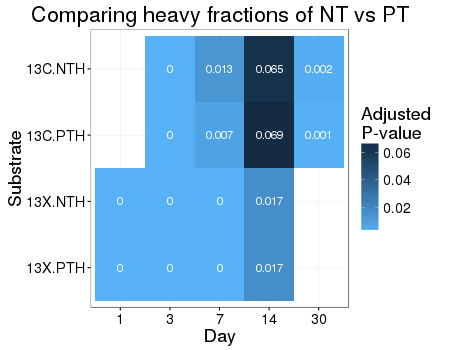

In [54]:
%%R -h 350 -w 450
# plotting
q_value_cutoff = 0.02
adonis.pval = adonis.pval %>%
    mutate(significant = q_value < q_value_cutoff) %>%
    filter(Substrate != 'blank')

adonis.pval$Day = reorder(adonis.pval$Day, adonis.pval$Day %>% as.numeric)
u.sub = adonis.pval$Substrate %>% as.character %>% unique %>% sort(decreasing=T)
adonis.pval$Substrate = factor(adonis.pval$Substrate, levels=u.sub)
adonis.pval2 = filter(adonis.pval, !(is.na(significant)))


p.adonis = ggplot(adonis.pval2, aes(Day, Substrate, fill=q_value)) +
    geom_tile() +
    #geom_point(aes(color=significant), size=9, shape='*') +
    scale_fill_gradient('Adjusted\nP-value', high="#132B43", low="#56B1F7") +
    #scale_color_manual(values=c('white', 'red')) +
    scale_alpha_manual(values=c(0,1)) +
    theme_bw() +
    theme(
        text=element_text(size=18)
    ) + ggtitle("Comparing heavy fractions of NT vs PT") + geom_text(aes(label = round(q_value, digits = 3)), 
                                                                     color = 'white')
p.adonis

In [55]:
%%R
# pulling out R^2
## extract p-values
adonis.R2 = lapply(adonis.res, get.R2)
## format results
adonis.R2 = do.call(rbind, adonis.R2) %>%
    as.data.frame %>%
    mutate(Day = rownames(.)) %>%
    gather(Substrate, R2, -Day)
adonis.R2 %>% arrange(Substrate, as.numeric(Day))#%>% head(n=5)

   Day Substrate         R2
1    1   13C.NTH         NA
2    3   13C.NTH 0.37997936
3    7   13C.NTH 0.14846924
4   14   13C.NTH 0.09144067
5   30   13C.NTH 0.19628336
6    1   13C.PTH         NA
7    3   13C.PTH 0.37997936
8    7   13C.PTH 0.14846924
9   14   13C.PTH 0.09144067
10  30   13C.PTH 0.19628336
11   1   13X.NTH 0.52223581
12   3   13X.NTH 0.34022133
13   7   13X.NTH 0.34874192
14  14   13X.NTH 0.13527011
15  30   13X.NTH         NA
16   1   13X.PTH 0.52223581
17   3   13X.PTH 0.34022133
18   7   13X.PTH 0.34874192
19  14   13X.PTH 0.13527011
20  30   13X.PTH         NA
21   1     blank         NA
22   3     blank         NA
23   7     blank         NA
24  14     blank         NA
25  30     blank         NA


In [56]:
%%R
adonis.R2 %>% group_by(Substrate) %>% na.omit %>% summarise(mean = mean(R2), sd = sd(R2))

Source: local data frame [4 x 3]

  Substrate      mean        sd
      (chr)     (dbl)     (dbl)
1   13C.NTH 0.2040432 0.1248753
2   13C.PTH 0.2040432 0.1248753
3   13X.NTH 0.3366173 0.1582771
4   13X.PTH 0.3366173 0.1582771


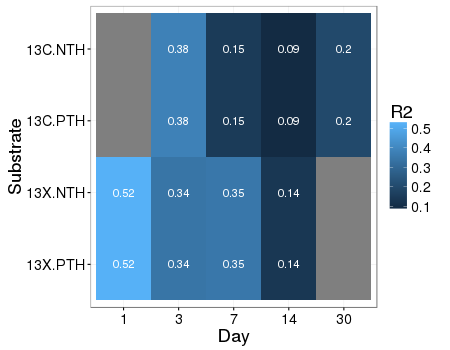

In [57]:
%%R -h 350 -w 450
# plotting
adonis.R2 = adonis.R2 %>%
    filter(Substrate != 'blank')

adonis.R2$Day = reorder(adonis.R2$Day, adonis.R2$Day %>% as.numeric)
u.sub = adonis.R2$Substrate %>% as.character %>% unique %>% sort(decreasing=T)
adonis.R2$Substrate = factor(adonis.R2$Substrate, levels=u.sub)

ggplot(adonis.R2, aes(Day, Substrate, fill=R2)) +
    geom_tile() +
    theme_bw() +
    theme(
        text=element_text(size=18) 
    )+ geom_text(aes(label = round(R2, digits = 2)), color = 'white')

In [58]:
%%R
total2 = left_join(adonis.pval2, adonis.R2)
total2 %>% as.data.frame

   Day Substrate    p_value     q_value significant         R2
1    3   13X.NTH 0.00019996 0.000399920        TRUE 0.34022133
2    7   13X.NTH 0.00019996 0.000399920        TRUE 0.34874192
3   14   13X.NTH 0.01419716 0.016682378        TRUE 0.13527011
4    1   13X.NTH 0.00019996 0.000399920        TRUE 0.52223581
5    3   13C.NTH 0.00019996 0.000399920        TRUE 0.37997936
6    7   13C.NTH 0.00979804 0.013064054        TRUE 0.14846924
7   14   13C.NTH 0.06118776 0.065266947       FALSE 0.09144067
8   30   13C.NTH 0.00139972 0.002239552        TRUE 0.19628336
9    3   13C.PTH 0.00019996 0.000399920        TRUE 0.37997936
10   7   13C.PTH 0.00499900 0.007271273        TRUE 0.14846924
11  14   13C.PTH 0.06858628 0.068586283       FALSE 0.09144067
12  30   13C.PTH 0.00059988 0.001066453        TRUE 0.19628336
13   3   13X.PTH 0.00019996 0.000399920        TRUE 0.34022133
14   7   13X.PTH 0.00019996 0.000399920        TRUE 0.34874192
15  14   13X.PTH 0.01459708 0.016682378        TRUE 0.1

In [59]:
%%R
total2$sig[total2$q_value <= 0.001] = "***"
total2$sig[total2$q_value <= 0.01 & total2$q_value > 0.001] = "**"
total2$sig[total2$q_value <= 0.05 & total2$q_value > 0.01] = "*"
total2$sig[total2$q_value > 0.05] = ""

In [60]:
%%R
total2

   Day Substrate    p_value     q_value significant         R2 sig
1    3   13X.NTH 0.00019996 0.000399920        TRUE 0.34022133 ***
2    7   13X.NTH 0.00019996 0.000399920        TRUE 0.34874192 ***
3   14   13X.NTH 0.01419716 0.016682378        TRUE 0.13527011   *
4    1   13X.NTH 0.00019996 0.000399920        TRUE 0.52223581 ***
5    3   13C.NTH 0.00019996 0.000399920        TRUE 0.37997936 ***
6    7   13C.NTH 0.00979804 0.013064054        TRUE 0.14846924   *
7   14   13C.NTH 0.06118776 0.065266947       FALSE 0.09144067    
8   30   13C.NTH 0.00139972 0.002239552        TRUE 0.19628336  **
9    3   13C.PTH 0.00019996 0.000399920        TRUE 0.37997936 ***
10   7   13C.PTH 0.00499900 0.007271273        TRUE 0.14846924  **
11  14   13C.PTH 0.06858628 0.068586283       FALSE 0.09144067    
12  30   13C.PTH 0.00059988 0.001066453        TRUE 0.19628336  **
13   3   13X.PTH 0.00019996 0.000399920        TRUE 0.34022133 ***
14   7   13X.PTH 0.00019996 0.000399920        TRUE 0.34874192

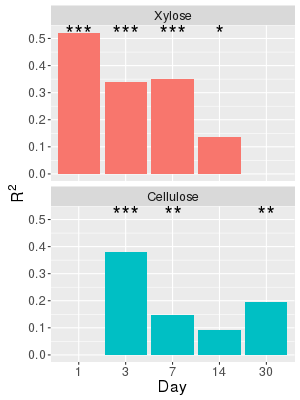

In [61]:
%%R -w 300 -h 400

total2$p_value_round = round(total2$p_value, digits = 3)
total2 = filter(total2, Substrate %in% c('13X.PTH', '13C.PTH'))

names = c(
                    '13X.PTH' = "Xylose",
                    '13C.PTH' = "Cellulose"
                    )

p = ggplot(total2, aes(x = Day, y = R2)) + geom_bar(stat = 'identity', position = 'dodge', aes(fill = Substrate)) + 
    facet_wrap(~Substrate, labeller = as_labeller(names), ncol = 1)


p = p + geom_text(data = total2, aes(label = sig), size = 8, y = 0.52)

p = p + theme(text = element_text(size = 16)) + ylab(expression('R'^ 2)) + guides(fill = FALSE)
p

# Weighted mean Unifrac vs BD (Replicate4 dataset)

* weights determined by % BD-range overlap (% overlap for 12C fractions)

In [62]:
%%R 

F = file.path(physeqDir, physeqSIP)
physeq.SIP = readRDS(F) 
physeq.SIP.m = physeq.SIP %>% sample_data

## removing replicate microcosm for 12C-Con (causes problems w/ comparisons)
physeq.SIP = prune_samples((physeq.SIP.m$Replicate == 4) & (physeq.SIP.m$Full.sample !='12C.NTH.D3.R4.Frac9')
                           , physeq.SIP)

physeq.SIP.m = physeq.SIP %>% sample_data
physeq.SIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]


In [63]:
%%R
tbl.meta = physeq.SIP %>% sample_data
u.day = tbl.meta$Day %>% unique

physeq.SIP.l = list()
for (d in as.character(u.day)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.SIP, Day == d)
    physeq.SIP.l[[d]] = subset_samples(tmp, ! is.na(Density))
    print(d)
    physeq.SIP.l[[d]] %>% print
    }

[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 142 samples ]
sample_data() Sample Data:       [ 142 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "7"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 140 samples ]
sample_data() Sample Data:       [ 140 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "14"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 139 samples ]
sample_data() Sample Data:       [ 139 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]
[1] "1"
phyloseq-class experiment-le

In [64]:
%%R

calc.wunif.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }

wunif.dist.l = lapply(physeq.SIP.l, calc.wunif.dist, cores=nprocs)

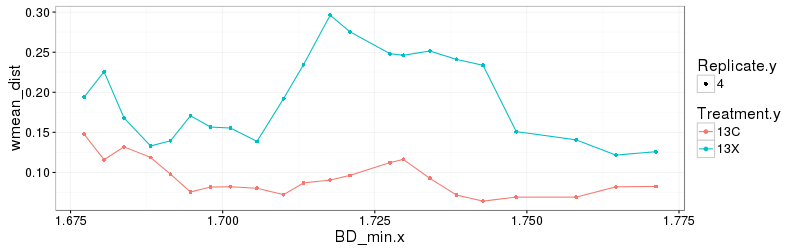

In [65]:
%%R -w 800 -h 250
# functions to reformat metadata & community beta div. distance matrix
## formatting metadata
as.Num = function(x) x %>% as.character %>% as.numeric

.max.BD.range = function(BD_range, BD_min, BD_max, BD_to_set){
    # if BD_range is negative, use BD_to_set value to set new BD_max
    if(BD_range <= 0){
        return(BD_min + BD_to_set)
    } else {
        return(BD_max)
    }
}

format.metadata = function(metadata){
    metadata = metadata %>% 
        as.matrix %>% as.data.frame %>%
        select(Full.sample, Day, Treatment, Replicate, Fraction, Density, Treatment) %>%
        rename('BD_min' = Density) %>%
        mutate(Fraction = Fraction %>% as.Num) %>%
        arrange(Day, Treatment, Replicate, -Fraction) %>%
        mutate(BD_min = BD_min %>% as.Num,
               BD_max = lead(BD_min),
               BD_max = ifelse(is.na(BD_max), BD_min, BD_max),
               BD_range = BD_max - BD_min) %>%
        group_by() %>%
        mutate(median_BD_range = median(BD_range, na.rm=T)) %>%
        ungroup() %>%
        mutate(BD_max = mapply(.max.BD.range, BD_range, BD_min, BD_max, BD_to_set=median_BD_range)) %>%
        mutate(BD_range = BD_max - BD_min) %>%
        select(-median_BD_range)
    return(metadata)
    }
    
## reformatting distance matrix
parse.dist = function(d){
    df = d %>% as.matrix %>% as.data.frame 
    df$sample = rownames(df)
    df = df %>% gather('sample.y', 'distance', -sample) %>%
        rename('sample.x' = sample) %>%
        filter(sample.x != sample.y)
    return(df)
    }

add.metadata = function(df, meta){
    df = inner_join(df, meta, c('sample.x' = 'Full.sample'))
    df = inner_join(df, meta, c('sample.y' = 'Full.sample'))
    return(df)
    }
    
cont.vs.treat = function(df){
    # filtering out comparisons of samples from same gradient (just keeping control vs treatment comparisons)
    #wunif.j %>% nrow %>% print
    #wunif.j = wunif.j %>%
    df = df %>%
        filter((Treatment.x == '12C' & 
                Treatment.y != '12C'))
    return(df)
    }

.perc.overlap = function(x.start, x.end, y.start, y.end){
    x.len = abs(x.end - x.start) + 1
    # largest start
    max.start = max(c(x.start, y.start))
    min.end = min(c(x.end, y.end))
    overlap = min.end - max.start
    overlap = ifelse(overlap <= 0, 0, overlap)
    perc_overlap = overlap / x.len * 100
    return(perc_overlap)
    }

BD.range.overlap = function(df){
    # determining BD_range % overlap (oriented to 12C control)
    df = df %>% 
        mutate(perc_overlap = mapply(.perc.overlap, BD_min.x, BD_max.x, BD_min.y, BD_max.y)) %>% 
        filter(perc_overlap > 0) # filtering to just overlapping fractions
    return(df)
    }

    
overlap.min.max.dist = function(df){    
    # determining min/max values for each set of overlapping fractions
    df.s = df %>%
        group_by(sample.x, Treatment.y, Replicate.y, BD_min.x) %>%
        summarize(n_overlap = n(),
                  min_dist = min(distance),
                  max_dist = max(distance))    
    return(df.s)
    }
    
overlap.wmean.dist = function(df){
    # calculating weighted mean distance 
    df.s = df %>% 
        group_by(sample.x, Treatment.y, Replicate.y, BD_min.x) %>%
        mutate(n_overlaps = n(),
               wmean_dist = weighted.mean(distance, perc_overlap)) %>%
        ungroup() %>%
        distinct(sample.x, Treatment.y, Replicate.y, wmean_dist) %>%
        mutate(Replicate.y = Replicate.y %>% as.character)
    return(df.s)
    }

    
beta.div.by.BD = function(d, meta){
    # wrapper function
    meta = format.metadata(meta)
    df = parse.dist(d)
    df = add.metadata(df, meta)
    df = cont.vs.treat(df)
    df = BD.range.overlap(df)
    #df = overlap.min.max.dist(df)
    df = overlap.wmean.dist(df)
    return(df)
}

#--test--#
tbl.NTH = filter(tbl.meta, Till == "N")
ret = beta.div.by.BD(wunif.dist.l[[1]], tbl.NTH)    
#ret %>% head(n=5)
ggplot(ret, aes(BD_min.x, wmean_dist, color=Treatment.y, shape=Replicate.y)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [66]:
%%R
# running on all distance matrices (matrix for each day)
tbl.NTH = filter(tbl.meta, Till == "N")
dist.wmean_NTH = lapply(wunif.dist.l, beta.div.by.BD, meta=tbl.NTH) 
dist.wmean_NTH = do.call(rbind, dist.wmean_NTH) 
dist.wmean_NTH %>% head(n=3) %>% as.data.frame

              sample.x             sample.y  distance Day.x Treatment.x
1 12C.NTH.D3.R4.Frac28 13X.NTH.D3.R4.Frac28 0.1809751     3         12C
2 12C.NTH.D3.R4.Frac27 13X.NTH.D3.R4.Frac28 0.2481497     3         12C
3 12C.NTH.D3.R4.Frac21 13X.NTH.D3.R4.Frac21 0.1339275     3         12C
  Replicate.x Fraction.x BD_min.x BD_max.x BD_range.x Day.y Treatment.y
1           4         28 1.677228 1.680507   0.003279     3         13X
2           4         27 1.680507 1.683785   0.003278     3         13X
3           4         21 1.701269 1.705640   0.004371     3         13X
  Replicate.y Fraction.y BD_min.y BD_max.y BD_range.y perc_overlap n_overlaps
1           4         28 1.678321 1.681599   0.003278    0.2178856          2
2           4         28 1.678321 1.681599   0.003278    0.1088432          2
3           4         21 1.704547 1.706733   0.002186    0.1088243          2
  wmean_dist
1  0.1938993
2  0.2256916
3  0.1554705


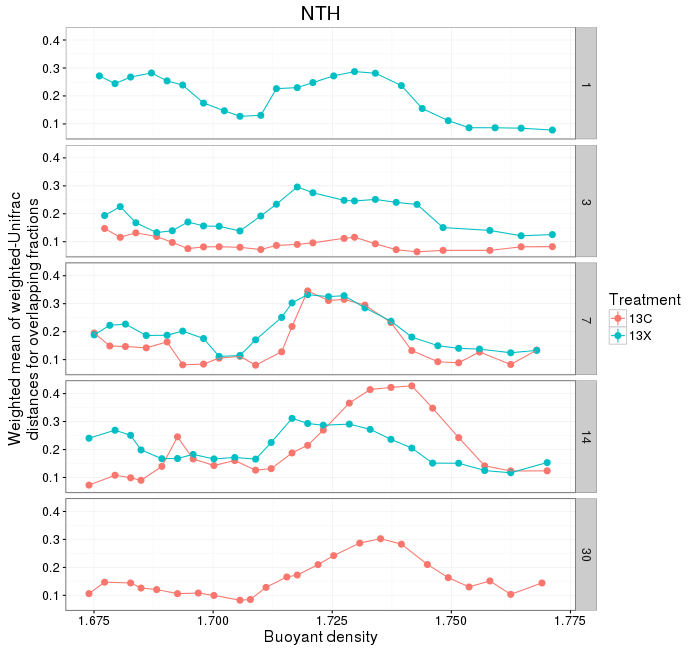

In [67]:
%%R -w 700 -h 650

dist.wmean.s.N = dist.wmean_NTH %>%
    mutate(Day.y = Day.y %>% as.character) %>%
    group_by(Day.y, Treatment.y, BD_min.x) %>%
    summarize(mean_wmean_dist = mean(wmean_dist),
              se_wmean_dist = sd(wmean_dist) / sqrt(length(wmean_dist)))
    
dist.wmean.s.N$Day.y = reorder(dist.wmean.s.N$Day.y, dist.wmean.s.N$Day.y %>% as.numeric)

p.wmean = ggplot(dist.wmean.s.N, aes(BD_min.x, mean_wmean_dist, color=Treatment.y)) +
    geom_pointrange(aes(ymin=mean_wmean_dist,# - se_wmean_dist,
                        ymax=mean_wmean_dist))+ #+ se_wmean_dist))# +
    geom_line() + #+
    scale_color_discrete('Treatment') +
    labs(x='Buoyant density',
         y='Weighted mean of weighted-Unifrac\ndistances for overlapping fractions') +
    facet_grid(Day.y ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + ggtitle("NTH")
p.wmean

In [68]:
%%R

outFile = 'wUnif_fracOlap_allData.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.wmean, height=7, width=8)

In [69]:
%%R
# running on all distance matrices (matrix for each day)
tbl.PTH = filter(tbl.meta, Till == "P")
dist.wmean_PTH = lapply(wunif.dist.l, beta.div.by.BD, meta=tbl.PTH) 
dist.wmean_PTH = do.call(rbind, dist.wmean_PTH) 
dist.wmean_PTH %>% head(n=3) %>% as.data.frame

              sample.x             sample.y  distance Day.x Treatment.x
1 12C.PTH.D3.R4.Frac12 13C.PTH.D3.R4.Frac12 0.1063394     3         12C
2 12C.PTH.D3.R4.Frac13 13C.PTH.D3.R4.Frac12 0.1045667     3         12C
3 12C.PTH.D3.R4.Frac24 13C.PTH.D3.R4.Frac23 0.1681746     3         12C
  Replicate.x Fraction.x BD_min.x BD_max.x BD_range.x Day.y Treatment.y
1           4         12 1.737330 1.741701   0.004371     3         13C
2           4         13 1.731866 1.737330   0.005464     3         13C
3           4         24 1.690341 1.693620   0.003279     3         13C
  Replicate.y Fraction.y BD_min.y BD_max.y BD_range.y perc_overlap n_overlaps
1           4         12 1.736237 1.740608   0.004371    0.3263734          2
2           4         12 1.736237 1.740608   0.004371    0.1087060          2
3           4         23 1.692527 1.695805   0.003278    0.1089428          2
  wmean_dist
1  0.1081662
2  0.1180266
3  0.1140454


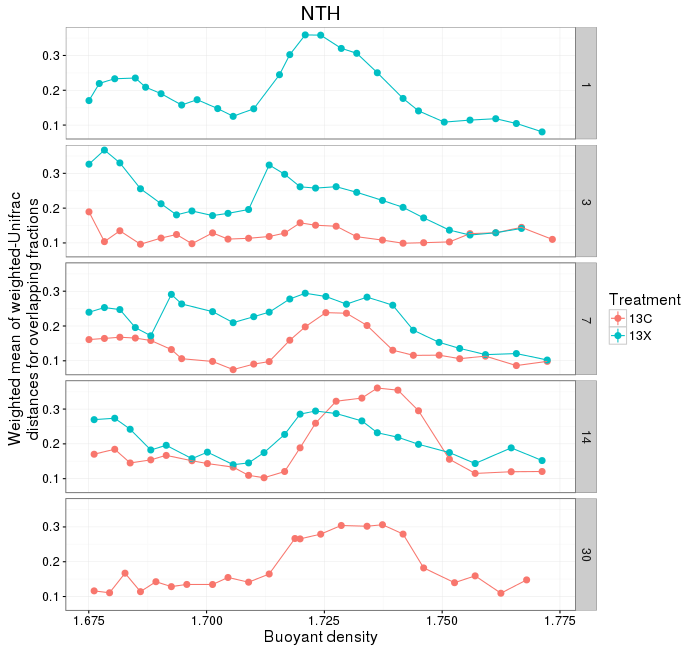

In [70]:
%%R -w 700 -h 650

dist.wmean.s.P = dist.wmean_PTH %>%
    mutate(Day.y = Day.y %>% as.character) %>%
    group_by(Day.y, Treatment.y, BD_min.x) %>%
    summarize(mean_wmean_dist = mean(wmean_dist),
              se_wmean_dist = sd(wmean_dist) / sqrt(length(wmean_dist)))
    
dist.wmean.s.P$Day.y = reorder(dist.wmean.s.P$Day.y, dist.wmean.s.P$Day.y %>% as.numeric)

p.wmean = ggplot(dist.wmean.s.P, aes(BD_min.x, mean_wmean_dist, color=Treatment.y)) +
    geom_pointrange(aes(ymin=mean_wmean_dist,# - se_wmean_dist,
                        ymax=mean_wmean_dist))+ #+ se_wmean_dist))# +
    geom_line() + #+
    scale_color_discrete('Treatment') +
    labs(x='Buoyant density',
         y='Weighted mean of weighted-Unifrac\ndistances for overlapping fractions') +
    facet_grid(Day.y ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + ggtitle("NTH")
p.wmean

In [71]:
%%R
dist.wmean.s.N$Soil = 'No-till'
dist.wmean.s.P$Soil = 'Till'
dist.wmean.Total = rbind(dist.wmean.s.N, dist.wmean.s.P)

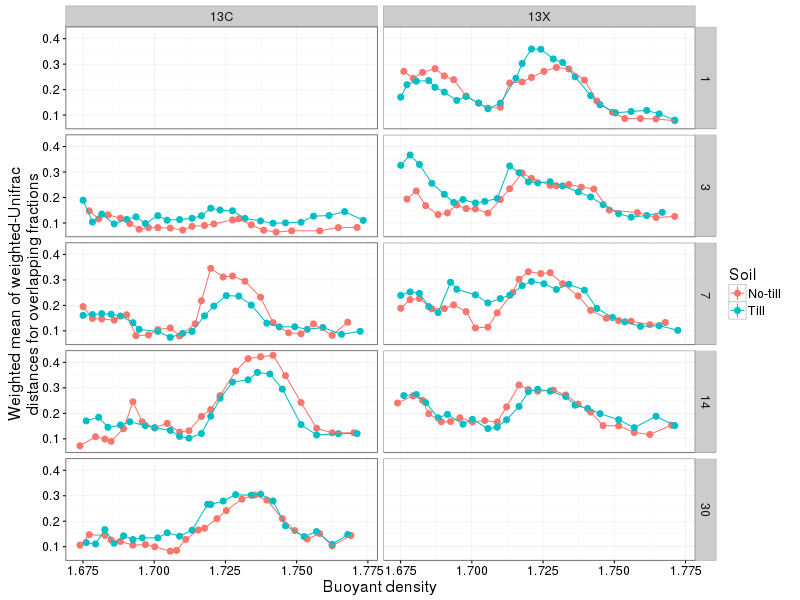

In [72]:
%%R -w 800 -h 600
p.wmean = ggplot(dist.wmean.Total, aes(BD_min.x, mean_wmean_dist, color=Soil)) +
    geom_pointrange(aes(ymin=mean_wmean_dist,# - se_wmean_dist,
                        ymax=mean_wmean_dist))+ #+ se_wmean_dist))# +
    geom_line() + #+
    scale_color_discrete('Soil') +
    labs(x='Buoyant density',
         y='Weighted mean of weighted-Unifrac\ndistances for overlapping fractions') +
    facet_grid(Day.y ~ Treatment.y) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.wmean

In [73]:
%%R
filter(dist.wmean.Total, Treatment.y == '13C', Soil == 'No-till') %>% as.data.frame

   Day.y Treatment.y BD_min.x mean_wmean_dist se_wmean_dist    Soil
1     14         13C 1.673950      0.07275110            NA No-till
2     14         13C 1.679414      0.10815641            NA No-till
3     14         13C 1.682692      0.09896773            NA No-till
4     14         13C 1.684878      0.09005576            NA No-till
5     14         13C 1.689249      0.13980555            NA No-till
6     14         13C 1.692527      0.24537678            NA No-till
7     14         13C 1.695805      0.16635796            NA No-till
8     14         13C 1.700176      0.14278454            NA No-till
9     14         13C 1.704547      0.16068921            NA No-till
10    14         13C 1.708918      0.12628516            NA No-till
11    14         13C 1.712197      0.13171494            NA No-till
12    14         13C 1.716568      0.18786677            NA No-till
13    14         13C 1.719846      0.21491486            NA No-till
14    14         13C 1.723124      0.26953675   

# Weighted mean Unifrac vs BD (core dataset)

* 'core' dataset
* weights determined by % BD-range overlap (% overlap for 12C fractions)

In [74]:
%%R 

F = file.path(physeqDir, physeqSIPcore)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data
physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3910 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3910 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3910 tips and 3909 internal nodes ]


In [75]:
%%R 
# sparcity.thresh = 0.35

# # filtering/normalizing
# physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
# physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (sparcity.thresh * length(x)), TRUE)
    
# # filtering to just SIP Samples
# physeq.thresh.m = physeq.thresh %>% sample_data
# physeq.thresh = prune_samples(physeq.thresh.m$Exp_type == 'SIP' &
#                               physeq.thresh.m$Sample_type == 'unknown' &
#                               physeq.thresh.m$core_dataset == TRUE, physeq.thresh)
# physeq.thresh.m = physeq.thresh %>% sample_data    
    
# print(physeq.thresh)

NULL


In [76]:
%%R
tbl.meta = physeq.SIP.core %>% sample_data
u.day = tbl.meta$Day %>% unique

physeq.SIP.core.l = list()
for (d in as.character(u.day)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.SIP.core, Day == d)
    physeq.SIP.core.l[[d]] = subset_samples(tmp, ! is.na(Buoyant_density))
    print(d)
    physeq.SIP.core.l[[d]] %>% print
    }


Error in eval(expr, envir, enclos) : object 'Buoyant_density' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Buoyant_density' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 50 or more warnings (use warnings() to see the first 50)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [77]:
%%R 

calc.wunif.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }

wunif.dist.l = lapply(physeq.SIP.core.l, calc.wunif.dist, cores=nprocs)

In [78]:
%%R
# running on all distance matrices (matrix for each day)
dist.wmean = lapply(wunif.dist.l, beta.div.by.BD, meta=physeq.SIP.core.m) 
dist.wmean = do.call(rbind, dist.wmean) 
dist.wmean %>% head(n=3) %>% as.data.frame

data frame with 0 columns and 0 rows


In [79]:
%%R -w 700 -h 650

dist.wmean.f = dist.wmean %>%
    mutate(Day.y = Day.y %>% as.character) 

dist.wmean.f$Day.y = reorder(dist.wmean.f$Day.y, dist.wmean.f$Day.y %>% as.numeric)

p.wmean = ggplot(dist.wmean.f, aes(BD_min.x, wmean_dist, color=Substrate.y)) +
    geom_point(alpha=0.8) +
    geom_line(alpha=0.5) +
    scale_color_discrete('Substrate') +
    labs(x='Buoyant density',
         y='Weighted mean of weighted-Unifrac\ndistances for overlapping fractions') +
    facet_grid(Day.y ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=18)
    )
p.wmean


Error in UseMethod("mutate_") : 
  no applicable method for 'mutate_' applied to an object of class "NULL"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in UseMethod("mutate_") : 
  no applicable method for 'mutate_' applied to an object of class "NULL"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [80]:
%%R 
outFile = 'wUnif_fracOlap_coreData.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.wmean, height=7, width=8)

In [81]:
%%R -w 900 -h 650

dist.wmean.f = dist.wmean %>%
    mutate(Day.y = Day.y %>% as.character) 

dist.wmean.f$Day.y = reorder(dist.wmean.f$Day.y, dist.wmean.f$Day.y %>% as.numeric)

p.wmean.f = ggplot(dist.wmean.f, aes(BD_min.x, wmean_dist, color=Substrate.y)) +
    geom_point(alpha=0.8) +
    geom_line(alpha=0.5) +
    labs(x='Buoyant density',
         y='Weighted mean of weighted-Unifrac\ndistances for overlapping fractions') +
    facet_grid(Substrate.y ~ Day.y) +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90, vjust=0.5),
        axis.title.y = element_text(vjust=1),
        legend.position = 'none'
    )
p.wmean.f


Error in UseMethod("mutate_") : 
  no applicable method for 'mutate_' applied to an object of class "NULL"


In [82]:
%%R 

outFile = 'wUnif_fracOlap_coreData_facet.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.wmean.f, height=9.5, width=11)


Error in grid.draw(plot) : object 'p.wmean.f' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.draw(plot) : object 'p.wmean.f' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
